# Assignment 2
Import the required libraries and  load the data

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import california_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

(inputs, targets), (x_test, y_test) = california_housing.load_data(version='small',
                                        test_split=0.2)
print(inputs.shape, targets.shape)
print(x_test.shape, y_test.shape)

(480, 8) (480,)
(120, 8) (120,)


From the training set containing 480 samples, extract 100 samples for validation.

In [50]:
x_train = inputs[:380]
y_train = targets[:380]
x_val = inputs[380:]
y_val = targets[380:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(380, 8) (380,)
(100, 8) (100,)


Standardize the data by subtracting the mean and dividing by the standard deviation. Also divide the target values by 100 000.

In [51]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train -= mean
x_train /= std

x_test -= mean
x_test /= std

x_val -= mean
x_val /= std

y_train /= 1e5
y_test /= 1e5
y_val /= 1e5

Prepare two functions to plot the loss and the mean absolute error.

In [52]:
def plot_loss(history):
    plt.plot(history.history['loss'][10:], label='train loss')
    plt.plot(history.history['val_loss'][10:], label='val loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

def plot_mae(history):
    plt.plot(history.history['mae'][10:], label='train MAE')
    plt.plot(history.history['val_mae'][10:], label='val MAE')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error (in 100000 $)')

## Model 1
Model 1 consists of 3 hidden layers with 64, 64, and 32 neurons respectively. The model uses EarlyStopping with a patience of 30 epochs. The first and third hidden layers have a regularization term of 0.01, and ReLU activation is applied throughout.

In [53]:
model1 = Sequential([
    Input(shape=(8,)),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),

    Dense(64, activation='relu'),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),

    Dense(1)
])

model1.compile(optimizer='adam',loss='mse',metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=30)
history = model1.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)

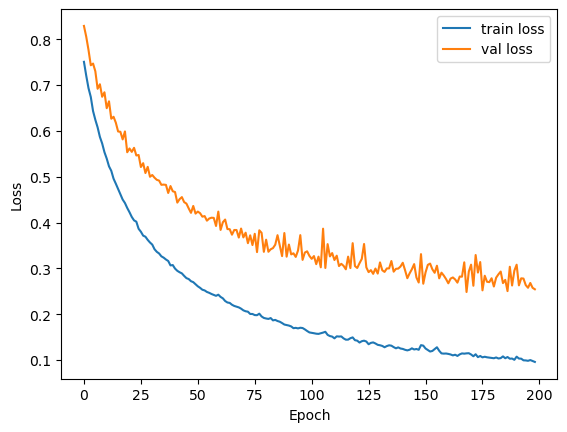

In [54]:
plot_loss(history)

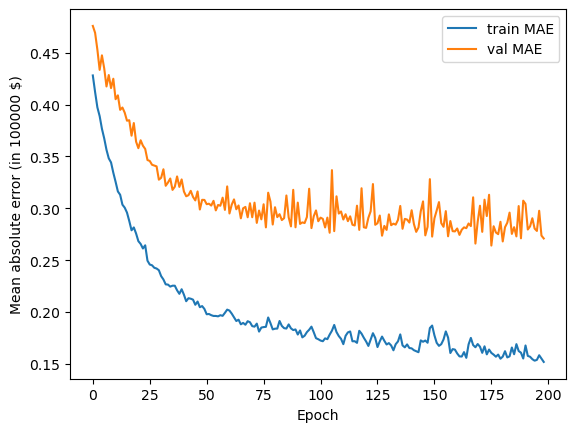

In [55]:
plot_mae(history)

Evaluate the model on the test set.

In [56]:
test_loss, test_mae = model1.evaluate(x_test, y_test)
print(f'Test mean average error: {test_mae:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3385 - mae: 0.3033
Test mean average error: 0.2959


### Model 1 conclusion
Model 1 achieves test MAEs of around 0.28/0.29 which is 0.2/0.1 lower than the original. Batches needed to learn is around 180-200. The model has L2 regularization on every layer and early stopping with a patience of 10 epochs, but the results are random and the model did not learn aswell as with fewer L2 regularization layers and a higher patience.

## Model 2
Model 2 consists of 4 hidden layers with 128, 128, 64, and 32 neurons respectively. The model uses EarlyStopping with a patience of 30 epochs. The first, third, and last hidden layers have a regularization term of 0.01. Dropout of 0.3 is applied after each hidden layer, and LeakyReLU activation with an alpha of 0.2 is used throughout.


In [57]:
model2 = Sequential([
    Input(shape=(8,)),

    Dense(128, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    BatchNormalization(),

    Dense(128),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.2),

    Dense(32),
    LeakyReLU(alpha=0.2),

    Dense(1)
])


model2.compile(optimizer='adam', loss='mse', metrics=["mae"])

history2 = model2.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=0, callbacks=[early_stopping])

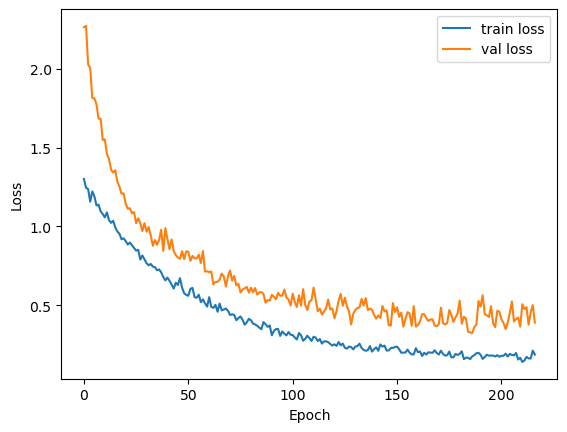

In [58]:
plot_loss(history2)

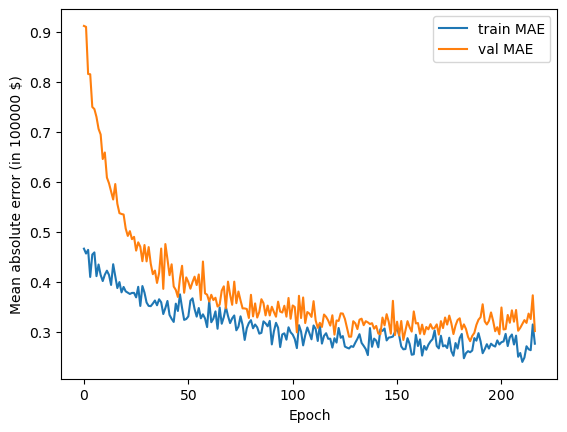

In [59]:
plot_mae(history2)

In [60]:
test_loss, test_mae = model2.evaluate(x_test, y_test)
print(f'Test mean average error: {test_mae:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3407 - mae: 0.2934
Test mean average error: 0.2849


### Model 2 conclusion
Model 2 achieves the same test MAE as Model 1, around 0.28/0.29. Batches needed to learn is around 140. The model had a more regularized structure than the first model. The model was also tested with more neurons (128, 256) and with more layers (5, 6) but the model did not learn aswell with the bigger structure.

 ## Model 2 full training
Train model 2 on both the training and validation sets combined. Evaluate the model on the test set.

In [61]:
x_train_full = np.concatenate((x_train, x_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)
history3 = model2.fit(x_train_full, y_train_full, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=0, callbacks=[early_stopping])

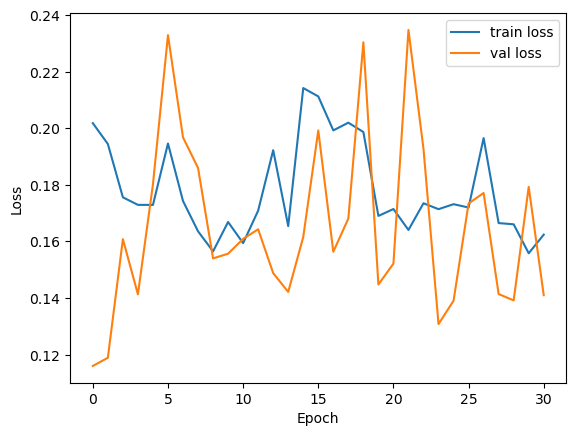

In [62]:
plot_loss(history3)

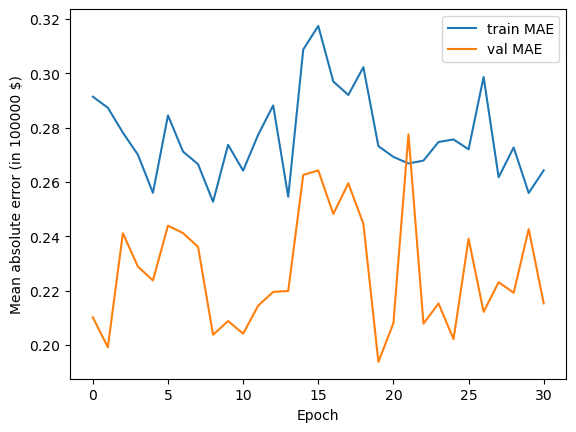

In [63]:
plot_mae(history3)

In [64]:
test_loss, test_mae = model2.evaluate(x_test, y_test)
print(f'Test mean average error: {test_mae:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3140 - mae: 0.2806 
Test mean average error: 0.2753


### Model 2 full training conclusion
Model 2 achieves a test MAE of around 0.26-0.28 after training with the concatenated dataset(training, validation). Model 2 learns faster with this dataset.